In [1]:
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils

import torchvision
import torch.nn as nn 
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import torch 
from typing import Dict, Any, List
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import collections

/mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [6]:
model_list = os.listdir("./02.ckpts")
sorted_model = sorted(model_list, key=lambda x: int(x.split('_')[1]))
print(sorted_model)
ckpt = sorted_model[-1]

print("#------------------------- Load")
print(ckpt)

['ver_25_FACE_Detection_FasterRCNN_epoch_10_iteration_1254.pt', 'ver_25_FACE_Detection_FasterRCNN_epoch_0_iteration_114.pt', 'ver_25_00.Model_Develope.py', 'ver_30_FACE_Detection_FasterRCNN_epoch_40_iteration_7011.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_80_iteration_13851.pt', 'ver_30_00.Model_Develope.py', 'ver_30_FACE_Detection_FasterRCNN_epoch_120_iteration_20691.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_0_iteration_171.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_30_iteration_5301.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_90_iteration_15561.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_50_iteration_8721.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_10_iteration_1881.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_110_iteration_18981.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_70_iteration_12141.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_100_iteration_17271.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_60_iteration_10431.pt', 'ver_30_FACE_Detection_FasterRCNN_epoch_20_iterat

In [9]:
os.path.exists(  os.path.join("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/09.Oriented_RCNN/02.ckpts",ckpt)  )

True

In [29]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model




model = get_model_instance_segmentation(4)

model.load_state_dict(torch.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/ObjectDetection/Mask_n_Face/02.ckpts/ver_25_FACE_Detection_FasterRCNN_epoch_20_iteration_3591.pt" ))


<All keys matched successfully>

In [30]:
DEVICE = "cuda:1"
BATCH_SIZE = 2

data_transform = transforms.Compose([  
        transforms.ToTensor()
    ])

def collate_fn(batch):
    return tuple(zip(*batch))


dataset_ = RS_dataset.MaskDataset(data_transform, '/mnt/hdd/eric/.tmp_ipy/00.Data/FaceMaskDetection/images/')
test_dataset = RS_dataset.MaskDataset(data_transform, '/mnt/hdd/eric/.tmp_ipy/00.Data/FaceMaskDetection/test_images/')

train_dataloader = torch.utils.data.DataLoader(dataset_, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn,shuffle=False)

In [31]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds


#----------------------------------------
with torch.no_grad(): 
    
    model = model.to(DEVICE)
    
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(DEVICE) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[214.9818,  59.6502, 250.8327,  94.8012],
        [117.2518,   3.1347, 131.8377,  17.9239]], device='cuda:1'), 'labels': tensor([2, 2], device='cuda:1'), 'scores': tensor([0.9936, 0.9833], device='cuda:1')}, {'boxes': tensor([[219.4170,  99.9771, 257.2865, 137.0543],
        [130.5152, 108.0220, 177.0569, 151.3208],
        [165.6643,  89.9163, 179.4970, 109.4967],
        [303.5388, 130.4077, 331.3394, 159.2153],
        [ 29.6031,  88.9023,  44.9321, 104.1019],
        [ 41.0398, 109.4825,  66.7541, 140.4162],
        [ 83.2528,  84.3417,  94.5670,  98.0733],
        [  2.5403, 104.9419,  21.1990, 126.6194]], device='cuda:1'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.9994, 0.9987, 0.9976, 0.9881, 0.9743, 0.9722, 0.9667, 0.9435],
       device='cuda:1')}]


In [17]:
# pred_cpu = {}
# for k,v in pred[0].items():
#     pred_cpu[k] = v.detach().to("cpu")   
# pred_cpu

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


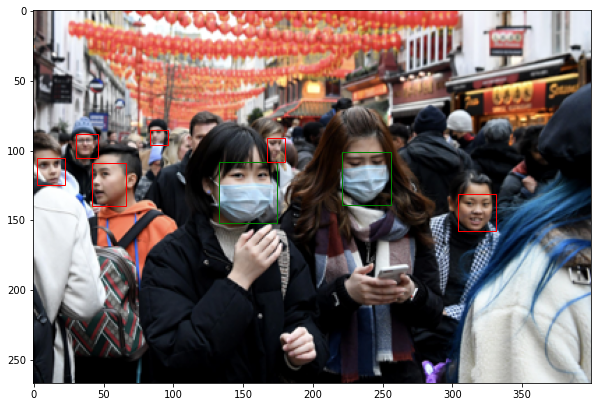

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:1')


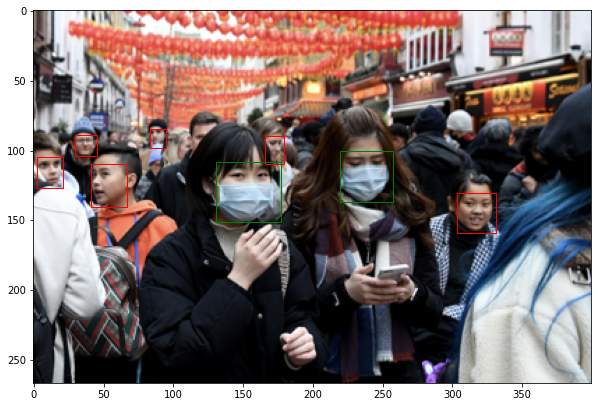

In [41]:
_idx = 1

print("Target : ", annotations[_idx]['labels'])
RS_utils.plot_image_from_output(imgs[_idx], annotations[_idx])

print("Prediction : ", pred[_idx]['labels'])
pred_cpu = {k: v.detach().to("cpu") for k, v in pred[_idx].items()}
RS_utils.plot_image_from_output(imgs[_idx], pred_cpu)

In [33]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(DEVICE) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        
        model = model.to(DEVICE)
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to("cpu") for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot = [{k: v.to("cpu") for k, v in t.items()} for t in annot]
        annot_all.append(annot)

100%|██████████| 85/85 [00:20<00:00,  4.07it/s]


In [34]:
preds_adj_all.__len__()

85

In [35]:
len(annot_all)

85

In [36]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += RS_utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = RS_utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7547591120963583
AP : tensor([0.8354, 0.9343, 0.4945], dtype=torch.float64)


In [42]:
precision, recall, f1, ap_class

(tensor([0.8090, 0.9195, 0.7647]),
 tensor([0.8703, 0.9501, 0.5000]),
 tensor([0.8385, 0.9345, 0.6047]),
 tensor([1, 2, 3]))